# T_BANK_SIRIUS_RECSYS
# EDA
## Выполнил Егоров Александр



>-----

## Комментарий к ноутбуку

> Архивы с данными по выборкам не прилагается в github, т.к. его размер много больше 50 мб (git giant files issue). Их можно будет найти по следующим ссылкам:
>
> Данные по выборкам:
>> https://github.com/0x0000dead/sirius-tbank-recsys-task-2024 
> распаковать в папку data/ в корневой директории проекта, либо изменить путь до данных в ноутбуке
>
> Ссылка на гугл диск со всеми данными к ноутбукам:
>> https://drive.google.com/drive/folders/12WS-cT-jWI7aschIoPzquMcWTTmSbIum?usp=sharing

Одна из целей EDA это отстроить графики и посмотреть, что и как происходит в данных: сделать визуализацию, чтобы красиво презентовать, построить какие-то гипотезы относительно данных для проведения A\B-тестирования. Однако в данном ноутбуке графического материала сделал по минимуму, т.к. посчитал, что для такого типа данных, а главное, **поставленной задачи** (реализация рекомендательной модели), большого смысла обширный EDA не несет: счел более важными размышления о том, какие данные и как можно использовать при построении модели &mdash; строить графики ради графиков не стал.

>----

# Библиотеки

In [1]:
import numpy as np
import pandas as pd

from typing import  Dict, Optional, Any

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import seaborn as sns

# USE THIS STYLE
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
# 
# OR THIS STYLE
import aquarel

import warnings

warnings.filterwarnings("ignore")

theme = aquarel.load_theme("arctic_light")
theme.set_font(family="serif")
theme.apply()

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Данные

In [2]:
data_folder = "./data/"

users = pd.read_csv(data_folder + "users_df.csv")
items = pd.read_csv(data_folder + "items_df.csv")

countries = pd.read_csv(data_folder + "countries.csv")
genres = pd.read_csv(data_folder + "genres.csv")
staff = pd.read_csv(data_folder + "staff.csv")

interactions = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
interactions = interactions.drop(columns=["is_train"])

test_df = pd.read_csv(data_folder + "test_data.csv")
test_df = test_df.groupby("user_id").agg({"movie_id": list}).reset_index()

## Бегло посмотрим на данные в таблицах: выведем основную информацию, чтобы понимать структуру данных

In [3]:
def display_df_main_info(df: pd.DataFrame):
    display(df.head(5))
    display(df.shape)
    display(df.dtypes)

In [4]:
display_df_main_info(users)

,user_id,age_category,income,sex,kids_flg,education
0,10250,35-44,NaN,NaN,0.0,Высшее
1,2062,18-24,NaN,Женский,0.0,Среднее
2,12980,35-44,NaN,Женский,1.0,Неполное высшее
3,30646,35-44,низкий,NaN,1.0,Высшее
4,43069,25-34,NaN,Женский,NaN,Высшее


(207377, 6)

user_id           int64
age_category     object
income           object
sex              object
kids_flg        float64
education        object
dtype: object

In [5]:
display_df_main_info(items)

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,..."
2,2,Детектив ди и тайна призрачного пламени,2010-01-01,NaN,"690 год нашей эры, Китай. Первая императрица д...","[294, 302]","[250, 117]","[3933, 19953, 32174, 30640, 14127, 32141, 2549...",NaN,NaN,NaN
3,3,Капитан,2017-01-01,2022-10-20T00:00:00,Вторая мировая война подходит к концу. В это в...,"[97, 303, 143, 319]","[188, 212, 0]","[16006, 12217, 30668, 28806, 16172, 5045, 1663...",NaN,NaN,NaN
4,4,Лазурный берег,2015-01-01,2023-01-12T00:00:00,У бывшей танцовщицы Ванессы и писателя Роланда...,"[138, 97]","[1, 102, 0]","[23586, 8823, 8040, 34555, 32484, 18446]",By the Sea,18.0,"Франция, отель, 1970-е, горе, путешествие, нес..."


(7427, 11)

id                    int64
title                object
year                 object
date_publication     object
description          object
genres               object
countries            object
staff                object
title_orig           object
age_rating          float64
keywords             object
dtype: object

In [6]:
display_df_main_info(interactions)

,id,datetime,user_id,movie_id,duration
0,0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0
1,1,2023-04-06 15:00:01.123928+03:00,2062,1521.0,129.0
2,2,2023-04-06 15:00:03.957246+03:00,12980,4598.0,2795.0
3,3,2023-04-06 15:00:04.990565+03:00,30646,5324.0,5094.0
4,4,2023-04-06 15:00:10.495017+03:00,43069,4291.0,75.0


(1251871, 5)

id            int64
datetime     object
user_id       int64
movie_id    float64
duration    float64
dtype: object

In [7]:
display_df_main_info(countries)
display_df_main_info(genres)
display_df_main_info(staff)

,id,name
0,0,Франция
1,1,Мальта
2,5,Новая Зеландия
3,8,Куба
4,10,Пуэрто-Рико


(100, 2)

id       int64
name    object
dtype: object

,id,name
0,2,Сказка
1,8,Здоровье
2,17,Наука
3,24,Комедийная мелодрама
4,38,Мистика


(96, 2)

id       int64
name    object
dtype: object

,id,name,role
0,0,Юрий Волынцев,actor
1,1,Коннор Смит,actor
2,2,Майкл Гандольфини,actor
3,3,Майкл Маркс,producer
4,4,Кад Мерад,actor


(35684, 3)

id       int64
name    object
role    object
dtype: object

In [8]:
display(interactions.head(2))
display(interactions.shape)

,id,datetime,user_id,movie_id,duration
0,0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0
1,1,2023-04-06 15:00:01.123928+03:00,2062,1521.0,129.0


(1251871, 5)

In [9]:
display(test_df.head(2))
display(test_df.shape)

,user_id,movie_id
0,0,"[12.0, 6201.0, 5542.0, 2025.0, 190.0, 5358.0, ..."
1,1,"[2515.0, 1540.0, 5210.0, 1608.0, 3590.0, 7215...."


(66900, 2)

# Пользователи

In [10]:
users.head()

,user_id,age_category,income,sex,kids_flg,education
0,10250,35-44,NaN,NaN,0.0,Высшее
1,2062,18-24,NaN,Женский,0.0,Среднее
2,12980,35-44,NaN,Женский,1.0,Неполное высшее
3,30646,35-44,низкий,NaN,1.0,Высшее
4,43069,25-34,NaN,Женский,NaN,Высшее


Посмотрим в каких столбцах есть незаполненные данные

In [11]:
for col in users.columns:
    print(f"{col}: {users[col].isna().unique()}")

user_id: [False]
age_category: [False  True]
income: [ True False]
sex: [ True False]
kids_flg: [False  True]
education: [False  True]


In [12]:
# Заполняем пропуски
users_default_values: Dict[str, Any] = {
    "age_category": "unknown",
    "income": "unknown",
    "sex": "unknown",
    "kids_flg": -1,
    "education": "unknown",
}
users.fillna(users_default_values, inplace=True)

Посмотрим как количество незаполненных полей соотносится с заполненными 

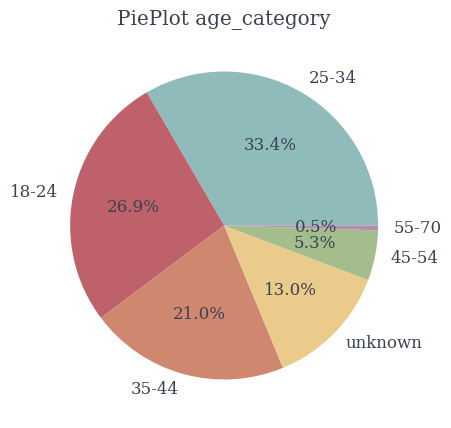

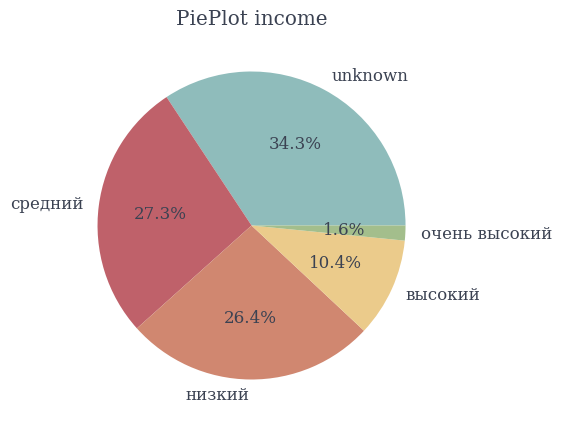

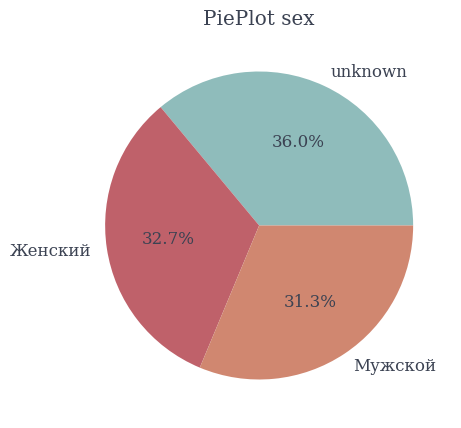

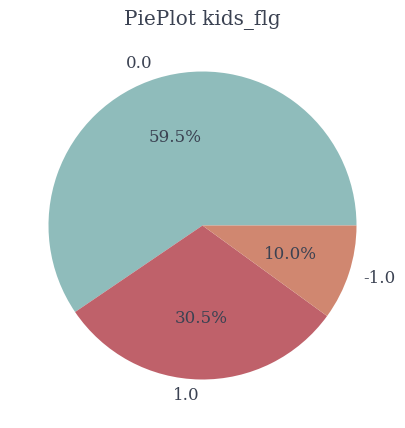

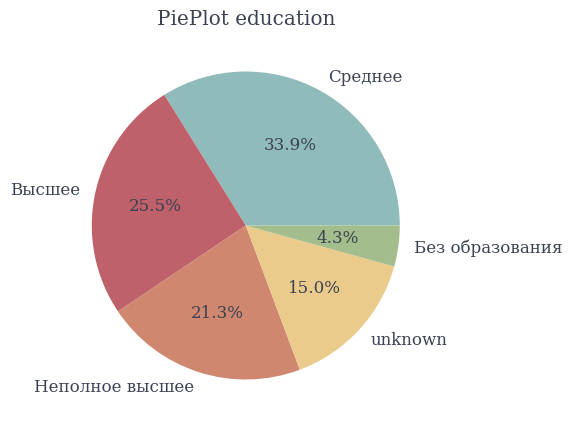

In [13]:
for col in users.columns[1:]:

    plt.figure(figsize=(7, 5))

    plt.title(f"PiePlot {col}")

    
    tmp = users[col].value_counts().reset_index()

    plt.pie(x=tmp["count"], labels=tmp[col], autopct="%1.1f%%" )
    plt.show()

В каждом случае unknown занимает большой процент в каждой колонке. Заполнять усредненными данными unknown значения смысла нет &mdash; оставим unknown отдельной категорией (значением) признака.

### Вывод по таблице users

Данная таблица, каждый ее столбец несет в себе смысл и будет использована при построении модели (т.к. в данном случае при рекомендации можно искать похожих пользователей (u2u-стратегия)) 


# Взаимодействия

In [14]:
interactions.head(1)

,id,datetime,user_id,movie_id,duration
0,0,2023-04-06 15:00:00.071114+03:00,10250,427.0,485.0


Посмотрим в каких столбцах есть незаполненные данные

In [15]:
for col in interactions.columns:
    print(f"{col}: {interactions[col].isna().unique()}")

id: [False]
datetime: [False]
user_id: [False]
movie_id: [False]
duration: [False]


Все колонки заполнены

## Преобразуем для удобства

In [16]:
interactions["datetime"] = pd.to_datetime(
    interactions["datetime"],
    format="ISO8601",
)
interactions["movie_id"] = interactions["movie_id"].apply(np.int64)
interactions["duration"] = interactions["duration"].apply(np.int64)
interactions = interactions.drop(columns=["id"])

display(interactions.head(2))

,datetime,user_id,movie_id,duration
0,2023-04-06 15:00:00.071114+03:00,10250,427,485
1,2023-04-06 15:00:01.123928+03:00,2062,1521,129


> **Наблюдение** 
>
> Сопоставляя колонку duration с реальной продолжительностью фильма, найденной с помощью поисковика, можно заключить, что duration - это количество секунд, которые пользователь провел за просмотром фильма. 

## Вывод по таблице interactions

В остальном из таблицы можно получить следующее:
- период, за который представлены данные,
- топ активности пользователей,
- топ самых популярных фильмов за период.


## Посмотрим за какой период представлены данные

In [17]:
max_date = interactions["datetime"].max()
min_date = interactions["datetime"].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")
print(f"Продолжительность: {max_date - min_date}")

min дата в interactions: 2023-04-06 15:00:00.071114+03:00
max дата в interactions: 2023-06-14 23:59:57.679860+03:00
Продолжительность: 69 days 08:59:57.608746


## Выведем топ 10 самых активных пользователей за 69 дней

In [18]:
top_10_users = interactions["user_id"].value_counts().index.values[:10]
top_10_users

array([  5,  21,   6,   4,  41,  51,  28,  38,  10, 263])

### Гипотеза
Например можно взять эвристику, персональный топ оп просмотру данных пользователей.

> **ЕСЛИ бы решалась задача оттока пользователей или удержания пользователей на платформе, ТО** можно начислять\предлагать\давать какие-либо бонусы самым активным пользователям, чтобы они продолжали активно пользоваться платформой

## Выведем топ 10 самых активных пользователей за последюю неделю

In [19]:
top_10_users_week = interactions[
    (interactions["datetime"] >= max_date - pd.Timedelta(days=7))
]["user_id"].value_counts().index.values[:10]
top_10_users_week

array([4500, 7173, 1163, 1804, 1385, 7429, 1557, 4923, 6495, 9409])

## Выведем 20 самых популярных фильмов за последние 69 дней

Предварительно посмотрим в каких столбцах есть незаполненные данные

In [20]:
for col in items.columns:
    print(f"{col}: {items[col].isna().unique()}")

id: [False]
title: [False]
year: [False]
date_publication: [False  True]
description: [False  True]
genres: [False]
countries: [False]
staff: [False]
title_orig: [ True False]
age_rating: [ True False]
keywords: [ True False]


In [21]:
top_20_pop = interactions["movie_id"].value_counts().index.values[:20]

### Предварительно рассмотрим значения таблицы items 

In [22]:
items.head(1)

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN


In [23]:
items["year"].isna().unique()

array([False])

Колонка `year` отображает год выпуска фильма, так что оставим только его 

In [24]:
items["year"] = pd.to_datetime(items["year"]).apply(lambda x: x.year)

### 20 самых популярных фильмов за весь промежуток

In [25]:
items[items["id"].isin(top_20_pop)]

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
484,484,Аватар: Путь воды,2023,2023-04-19T00:00:00,Джейк Салли живёт в образе аватара уже много л...,"[158, 294, 266, 302]",[102],"[15325, 23343, 18928, 23330, 5187, 30892, 1481...",NaN,NaN,NaN
641,641,Семейный бизнес,2021,2023-04-12T00:00:00,Герою предстоит сложный моральный выбор – помо...,[218],[102],"[5486, 22716, 19731, 13417, 11081, 31195, 2720...",NaN,NaN,NaN
1281,1281,13 минут,2021,2023-03-03T00:00:00,Трагическое событие обрушилось на небольшой го...,"[97, 303, 294]","[121, 102]","[11572, 2515, 26948, 13185, 2114]",NaN,NaN,NaN
1521,1521,Миньоны: Грювитация,2022,2023-03-30T00:00:00,"Великий и ужасный, но еще маленький Грю начина...","[46, 266, 304, 130]",[102],"[25296, 6034, 13340, 31102, 25501, 12149, 9210...",NaN,NaN,NaN
1978,1978,Веном 2,2021,2023-03-15T00:00:00,"Продолжение истории про Эдди Брока, в которого...","[294, 266, 326]","[117, 102]","[6975, 18398, 32284, 7376, 15174]",NaN,NaN,NaN
2074,2074,Морбиус,2022,2023-03-13T00:00:00,"Будучи десятилетним мальчиком, Майкл Морбиус з...","[294, 266, 326, 302]",[102],"[3186, 23895, 23373, 32494, 25884, 32063, 5121...",NaN,NaN,NaN
2480,2480,Аватар,2009,2023-01-11T00:00:00,Земляне неспроста стягивают все новые ресурсы ...,"[97, 158, 294, 266]",[102],"[29479, 23343, 10655, 21338, 6842, 6340, 17911...",NaN,NaN,NaN
2679,2679,Вечныe,2021,2023-03-06T00:00:00,"Вечные - сверхлюди, которые были созданы целес...","[97, 158, 294, 266, 302]",[102],"[12065, 8040, 28115, 30674, 6454, 27451, 6939,...",NaN,NaN,NaN
2820,2820,Алёша Попович и Тугарин Змей,2004,2022-01-01T00:00:00,«Алеша Попович и Тугарин Змей» (2004) — семейн...,[261],[238],"[9540, 4845, 17587, 11083, 5536, 26849, 17882,...",NaN,NaN,NaN
4090,4090,Старый Генри,2021,2023-04-12T00:00:00,Генри и его сын приютили раненого человека с с...,[218],[102],"[2500, 33078, 1297, 23112, 26795, 30372, 3453,...",NaN,NaN,NaN


## Выведем 10 самых популярных фильмов за последниюю неделю

In [26]:
top_20_items_week = interactions[
    (interactions["datetime"] >= max_date - pd.Timedelta(days=7))
]["movie_id"].value_counts().index.values[:20]
top_20_items_week

array([3415,  641, 5849, 1281, 4991, 2820, 6194,  484,  805,  475, 3092,
       3492, 5571, 1978, 1226, 4505, 1769, 2775, 6984, 3896])

In [27]:
items[items["id"].isin(top_20_items_week)]

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
475,475,2012,2009,2023-06-19T00:00:00,"А что, если индейцы майя не ошиблись, и в 2012...","[294, 266]",[102],"[18749, 19419, 15503, 9945, 23076, 31293]",2012,16.0,"цивилизация, гонка со временем, стихийное бедс..."
484,484,Аватар: Путь воды,2023,2023-04-19T00:00:00,Джейк Салли живёт в образе аватара уже много л...,"[158, 294, 266, 302]",[102],"[15325, 23343, 18928, 23330, 5187, 30892, 1481...",NaN,NaN,NaN
641,641,Семейный бизнес,2021,2023-04-12T00:00:00,Герою предстоит сложный моральный выбор – помо...,[218],[102],"[5486, 22716, 19731, 13417, 11081, 31195, 2720...",NaN,NaN,NaN
805,805,Охотник на монстров,2021,2023-03-15T00:00:00,"Адаптация знаменитой видеоигры, в центре сюжет...","[294, 302]","[188, 117, 102, 166]","[19177, 8710, 19663, 3872, 34318]",Monster hunter,16.0,"женщина-солдат, другое измерение, лук и стрела..."
1226,1226,Иван Царевич и Серый Волк,2011,2022-01-01T00:00:00,Однажды Иван Царевич решает заглянуть в Тридев...,"[158, 261]",[238],"[13165, 11604, 3722, 21988, 32097, 23400, 2692...",NaN,NaN,NaN
1281,1281,13 минут,2021,2023-03-03T00:00:00,Трагическое событие обрушилось на небольшой го...,"[97, 303, 294]","[121, 102]","[11572, 2515, 26948, 13185, 2114]",NaN,NaN,NaN
1769,1769,Гарфилд,2004,2023-01-11T00:00:00,"Жизнь кота Гарфилда кардинально меняется, когд...","[46, 261]",[102],"[29653, 31246, 23775, 23192, 30865, 28016, 564...",NaN,6.0,"Гарфилд, 2019, Франция, друзья, кошки, собаки,..."
1978,1978,Веном 2,2021,2023-03-15T00:00:00,"Продолжение истории про Эдди Брока, в которого...","[294, 266, 326]","[117, 102]","[6975, 18398, 32284, 7376, 15174]",NaN,NaN,NaN
2775,2775,Человек на Луне,2018,2023-03-20T00:00:00,История высадки на Луну астронавта Нила Армстр...,"[97, 124]","[117, 102, 166]","[33567, 6183, 10279, 11664, 8475, 34785, 29811...",First Man,12.0,"луна, основанная на романе или книге, НАСА, од..."
2820,2820,Алёша Попович и Тугарин Змей,2004,2022-01-01T00:00:00,«Алеша Попович и Тугарин Змей» (2004) — семейн...,[261],[238],"[9540, 4845, 17587, 11083, 5536, 26849, 17882,...",NaN,NaN,NaN


### Гипотеза
Взять эвристику, топ по просмотру за неделю \ месяц (эвристика: больше всего смотрели за...)

### Вспомним

типы данных в таблице `items`

In [28]:
items.dtypes


id                    int64
title                object
year                  int64
date_publication     object
description          object
genres               object
countries            object
staff                object
title_orig           object
age_rating          float64
keywords             object
dtype: object

Рассмотрим genres, countries, staff в приближении

In [29]:
display(items["genres"].values)
display(items["countries"].values)
display(items["staff"].values)

array(['[97]', '[138, 97, 294]', '[294, 302]', ..., '[138, 85]', '[247]',
       '[261]'], dtype=object)

array(['[238]', '[242]', '[250, 117]', ..., '[0]', '[238]', '[102]'],
      dtype=object)

array(['[1883, 33655, 25890, 1001, 12051, 10110, 16895]',
       '[18168, 23444, 10850, 21847, 30555, 24469, 26812, 11290, 16458, 33033, 7053]',
       '[3933, 19953, 32174, 30640, 14127, 32141, 2549, 7525, 25798, 31229, 33792, 31419, 12732, 28017, 17540, 23077, 27944, 5513, 19049, 17022, 4162]',
       ...,
       '[5828, 24468, 5125, 19939, 12752, 21851, 22674, 23632, 7863, 31820]',
       '[]',
       '[17245, 11259, 18449, 12897, 15908, 10901, 16447, 32468, 30031, 7676, 18341]'],
      dtype=object)

Это массивы из строк, следовательно, при составлении модели и подготовке данных значения из этих колонок придется парсить.

### Вывод по таблице Items

Из полезного из данных таблиц можно достать
- топ самых популярных участников съемочных групп, а учитывая таблицу `staff` можно будет выбрать их по категориям (актер, режисер, подюссер и т.д.),
- топ популярности жанров,
- топ стран, производящих фильмы,
- значения возрастного рейтинга.


# Остальное
По оставшимся таблицам можно сказать, следующее: 
в них содержатся данные с кодами к элементам колонок таблицы items, так что не придется вручную производить их кодировку.